# Loading Dataset

In [1]:
# IMPORTS
from sklearn.datasets import load_iris
import pandas as pd

In [2]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name="target")

# Exploratory Data Analysis

In [3]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Target Count
y.value_counts(normalize=True)

,proportion
target,
0,0.333333
1,0.333333
2,0.333333


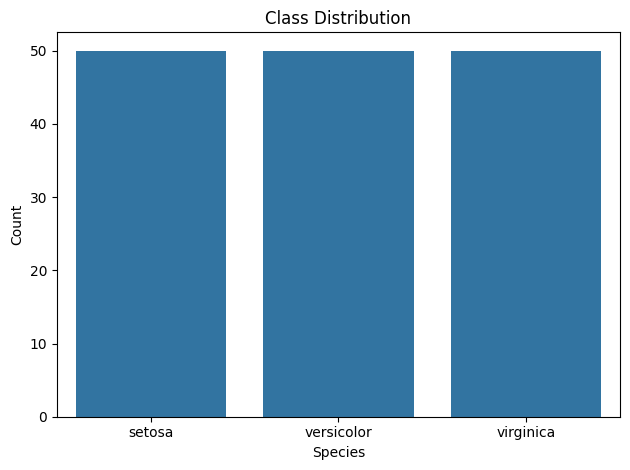

In [5]:
# Class distribution
sns.countplot(x='species', data=df)
plt.title("Class Distribution")
plt.xlabel("Species")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

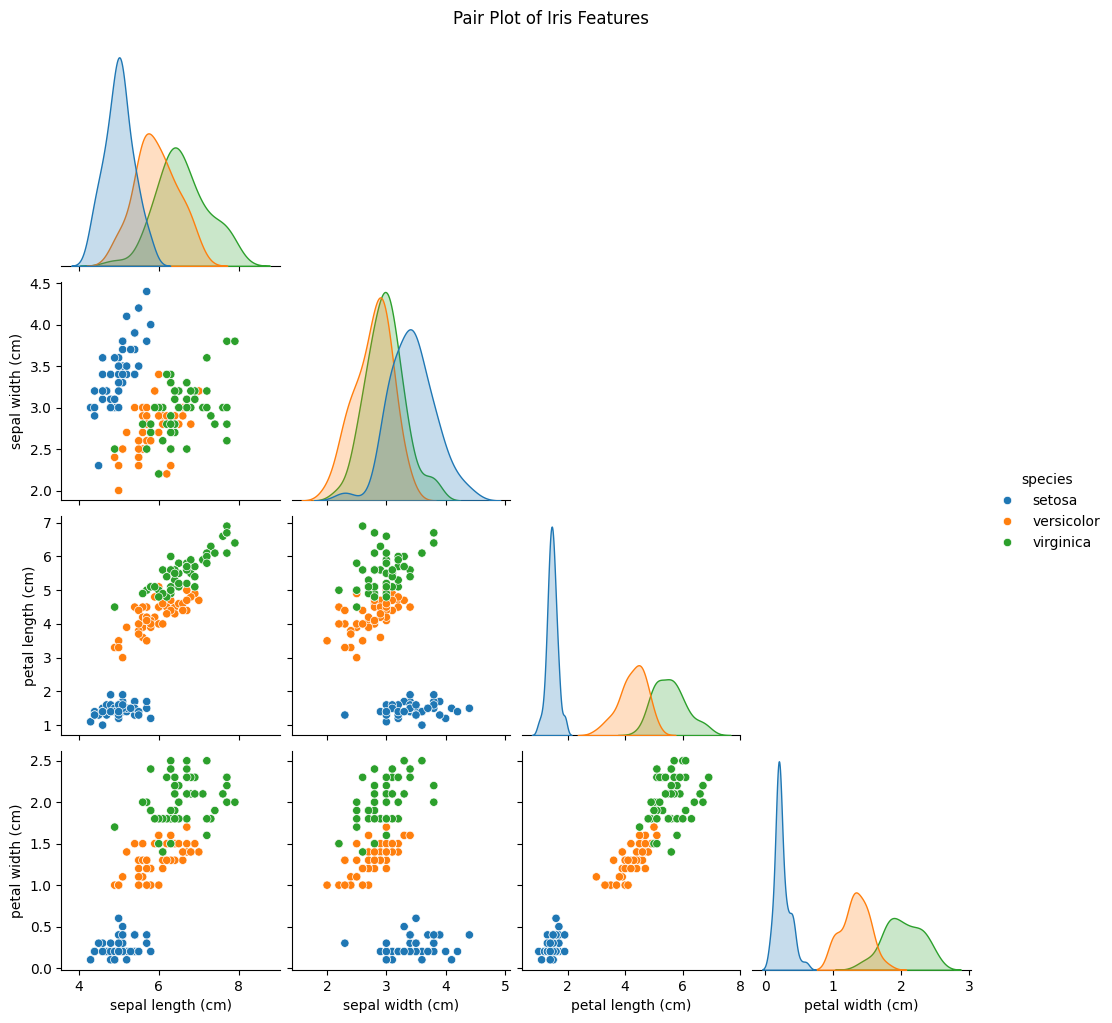

In [6]:
# Pair Plot
sns.pairplot(df, hue="species", corner=True)
plt.suptitle("Pair Plot of Iris Features", y=1.02)
plt.show()

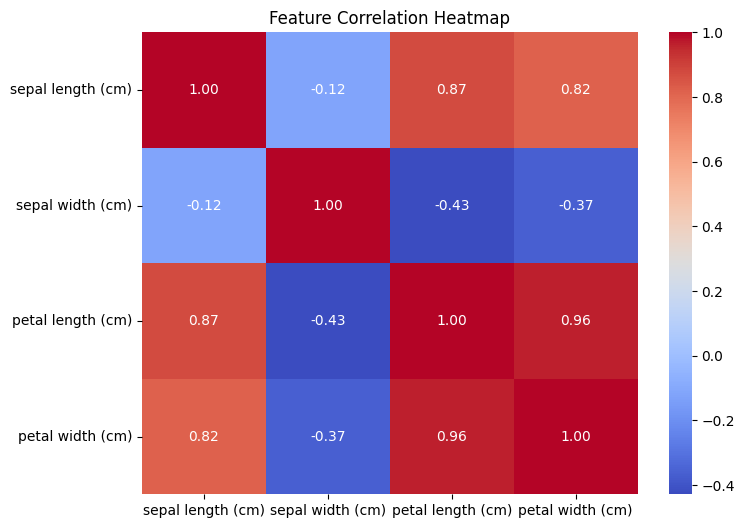

In [7]:
# Correlation Matrix
plt.figure(figsize=(8, 6))
correlation_matrix = df.drop(columns='species').corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

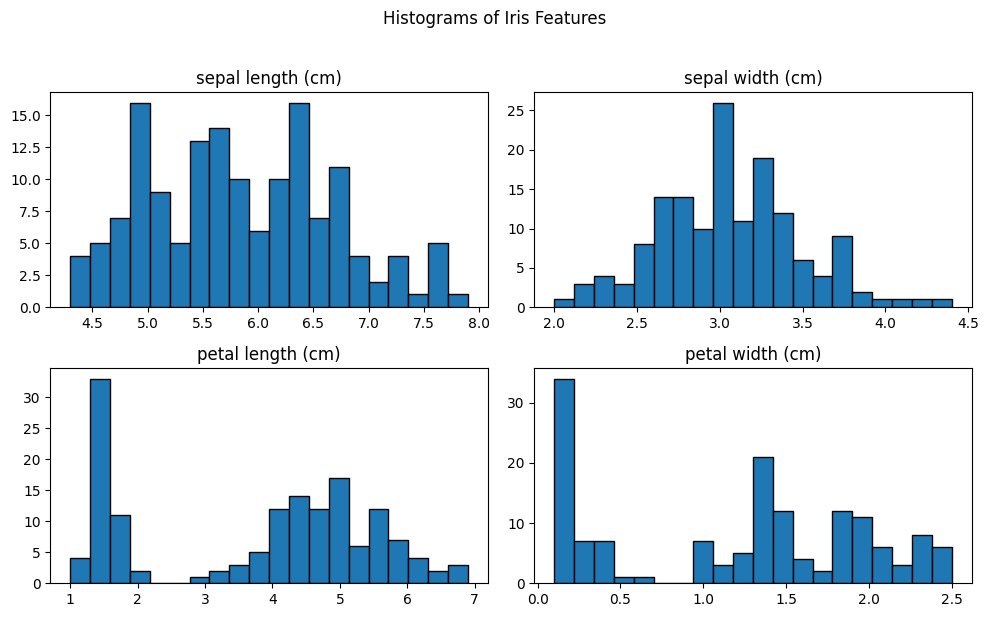

In [8]:
# Histogram
df.drop(columns='species').hist(bins=20, figsize=(10, 6), grid=False, edgecolor='black')
plt.suptitle("Histograms of Iris Features", y=1.02)
plt.tight_layout()
plt.show()

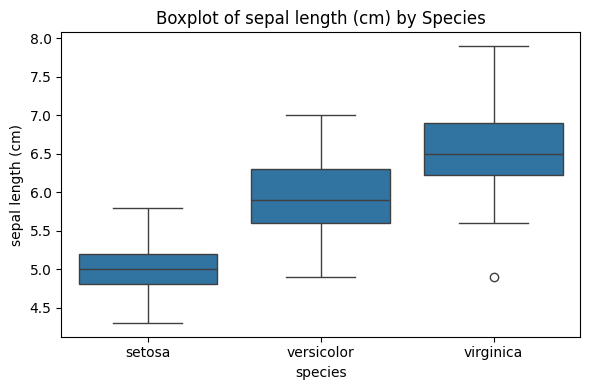

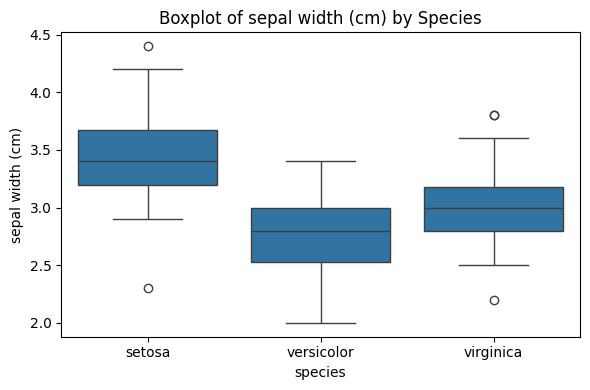

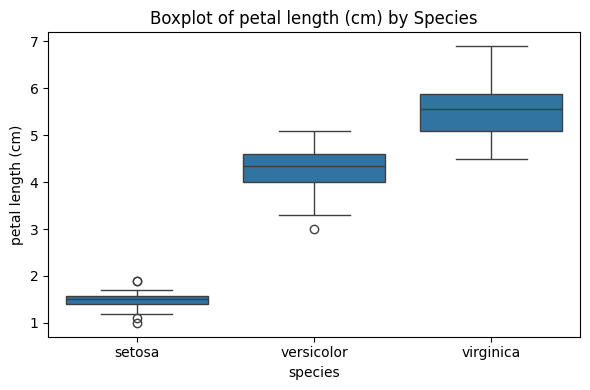

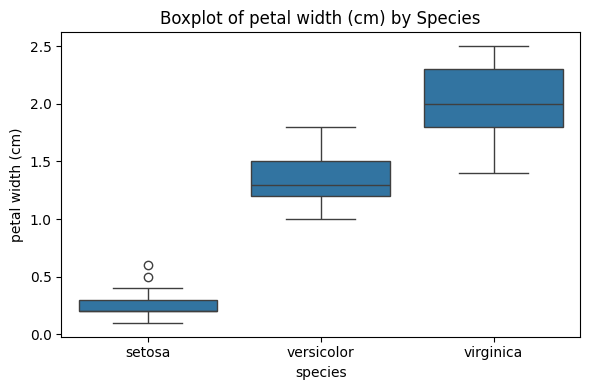

In [9]:
# Boxplot
for feature in iris.feature_names:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='species', y=feature, data=df)
    plt.title(f"Boxplot of {feature} by Species")
    plt.tight_layout()
    plt.show()


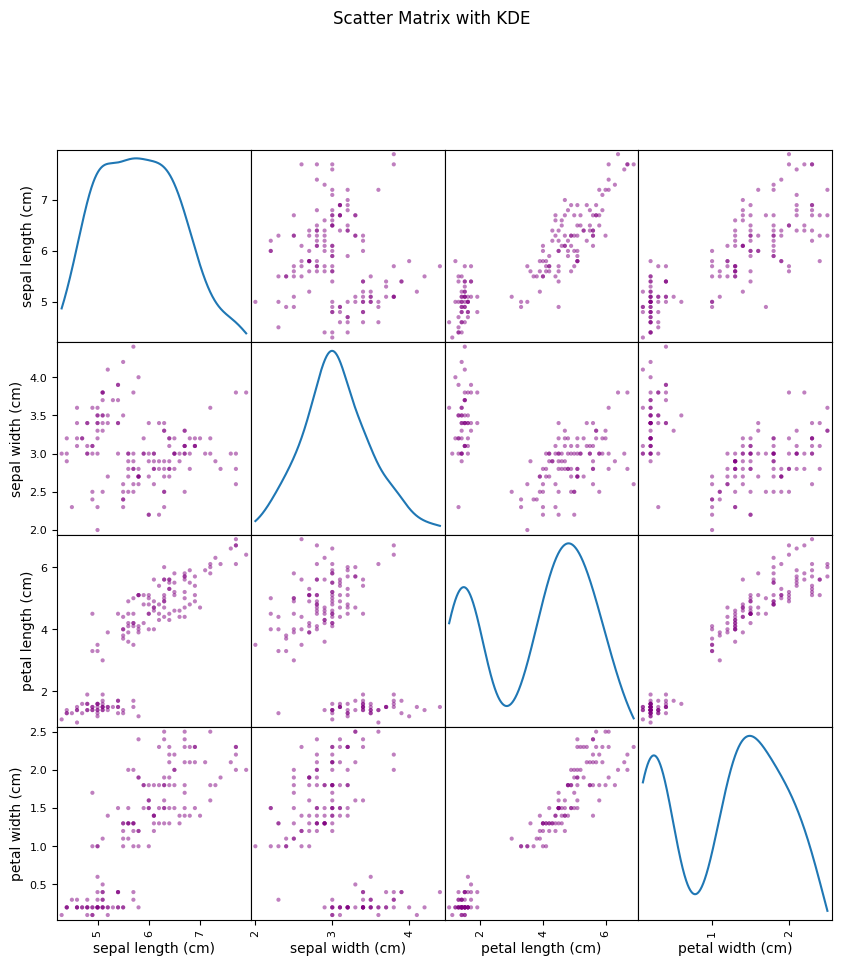

In [10]:
# Scatter matrix to explore pairwise relationships
from pandas.plotting import scatter_matrix
scatter_matrix(X, figsize=(10, 10), diagonal='kde', color='purple')
plt.suptitle("Scatter Matrix with KDE", y=1.02)
plt.show()

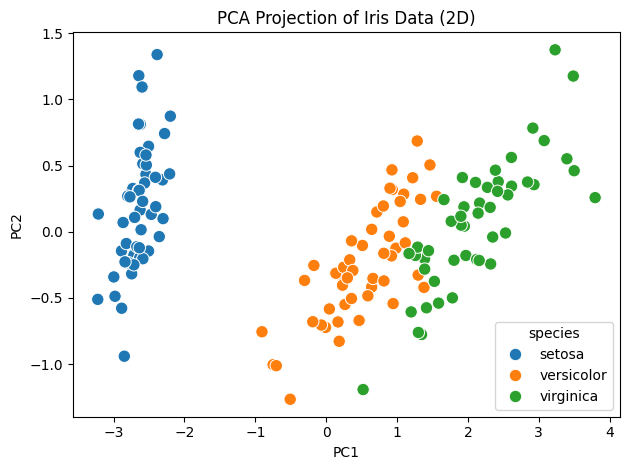

In [11]:
# PCA projection down to 2D for visual clustering
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["species"] = df["species"]

sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="species", s=80)
plt.title("PCA Projection of Iris Data (2D)")
plt.tight_layout()
plt.show()


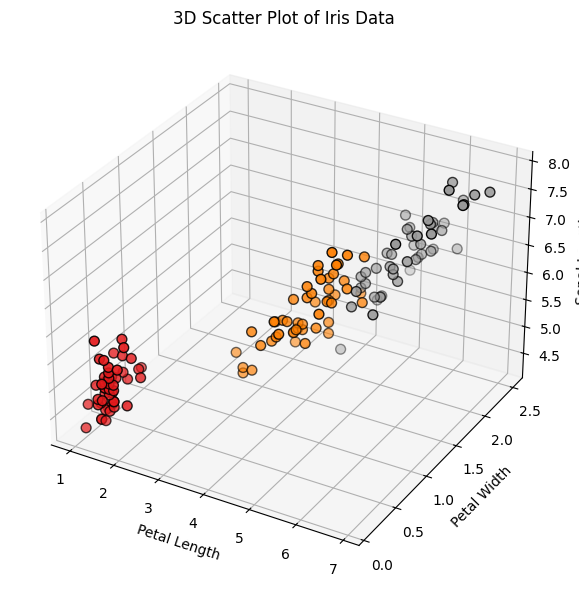

In [12]:
# 3D scatter plot of selected 3 features
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    X["petal length (cm)"],
    X["petal width (cm)"],
    X["sepal length (cm)"],
    c=y,
    cmap="Set1",
    edgecolor="k",
    s=50
)
ax.set_xlabel("Petal Length")
ax.set_ylabel("Petal Width")
ax.set_zlabel("Sepal Length")
ax.set_title("3D Scatter Plot of Iris Data")
plt.tight_layout()
plt.show()


# Data Preprocessing

In [3]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [4]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [5]:
# Scaling (for SVM, KNN, Logistic Regression, MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training & Comparison

In [9]:
# Imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "MLP": MLPClassifier(max_iter=1000)
}

results = []

for name, model in models.items():
    # Use scaled data only where needed
    if name in ["Logistic Regression", "SVM", "KNN", "MLP"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="macro"),
        "Recall": recall_score(y_test, y_pred, average="macro"),
        "F1 Score": f1_score(y_test, y_pred, average="macro")
    })

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:58:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:
# Display as DataFrame
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,XGBoost,0.933333,0.934524,0.933333,0.933259
1,SVM,0.933333,0.934524,0.933333,0.933259
2,Logistic Regression,0.911111,0.915535,0.911111,0.910714
3,MLP,0.911111,0.915535,0.911111,0.910714
4,Random Forest,0.911111,0.915535,0.911111,0.910714
5,KNN,0.911111,0.929825,0.911111,0.909502
6,Decision Tree,0.888889,0.889881,0.888889,0.888765


# XGBOOST ANALYSIS

In [12]:
# Imports
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Step 2: Predict on test set
y_pred = xgb_model.predict(X_test)

# Step 3: Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

Classification Report:

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      0.93      0.90        15
   virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



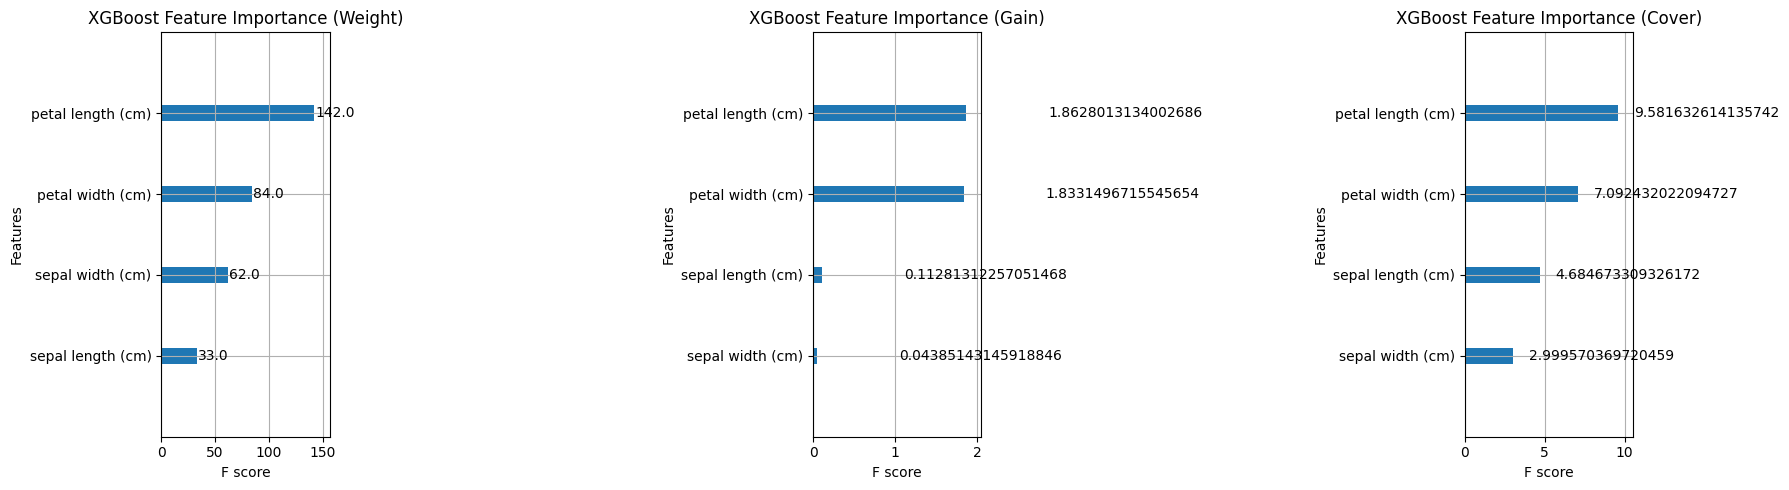

In [13]:
# Plot all three feature importance types: weight, gain, cover
importance_types = ['weight', 'gain', 'cover']
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, imp_type in enumerate(importance_types):
    xgb.plot_importance(xgb_model, importance_type=imp_type, ax=axs[i], title=f"XGBoost Feature Importance ({imp_type.capitalize()})", show_values=True)
    axs[i].set_xlabel("F score")
    axs[i].set_ylabel("Features")

plt.tight_layout()
plt.show()

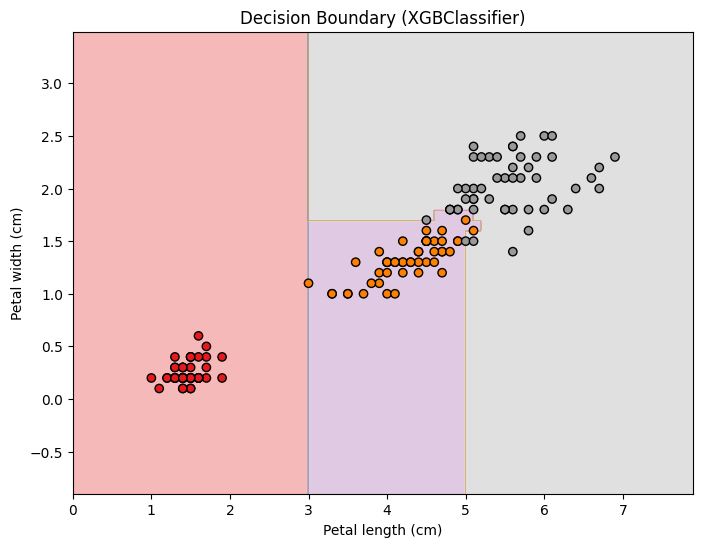

In [14]:
# DECISION BOUNDARIES FOR PETAL LENGTH VS WIDTH (IMPORTANT FEATURES)

# imports
import numpy as np

# Load data
iris = load_iris()
X = iris.data[:, [2, 3]]  # petal length and petal width
y = iris.target

# Train classifier
clf = XGBClassifier().fit(X, y)  # or LogisticRegression()

# Meshgrid for background
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict class for each point in the grid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.title("Decision Boundary (XGBClassifier)")
plt.show()


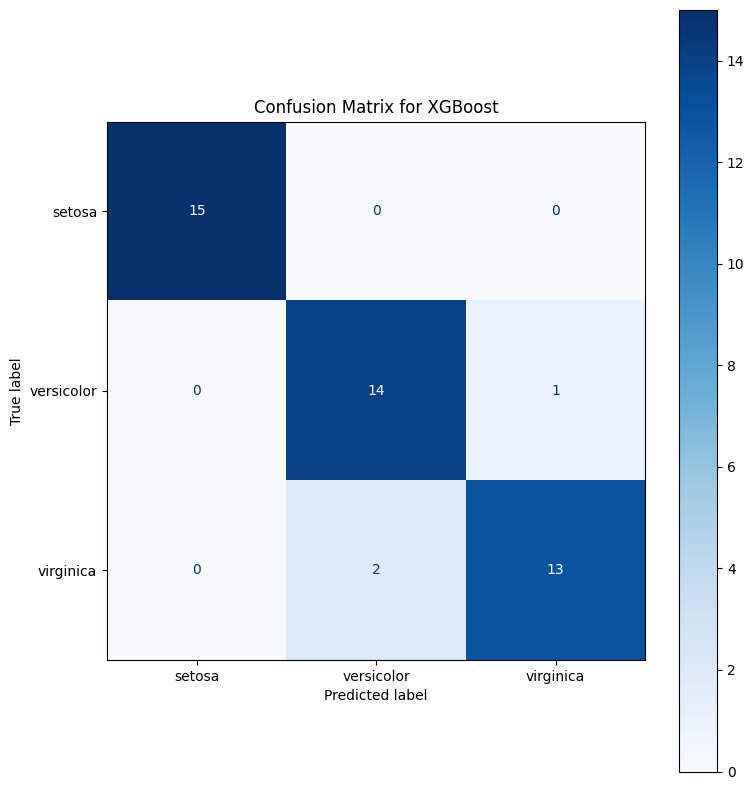

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Predict and generate confusion matrix
y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Set figure size BEFORE plotting
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix for XGBoost")
plt.tight_layout()
plt.show()


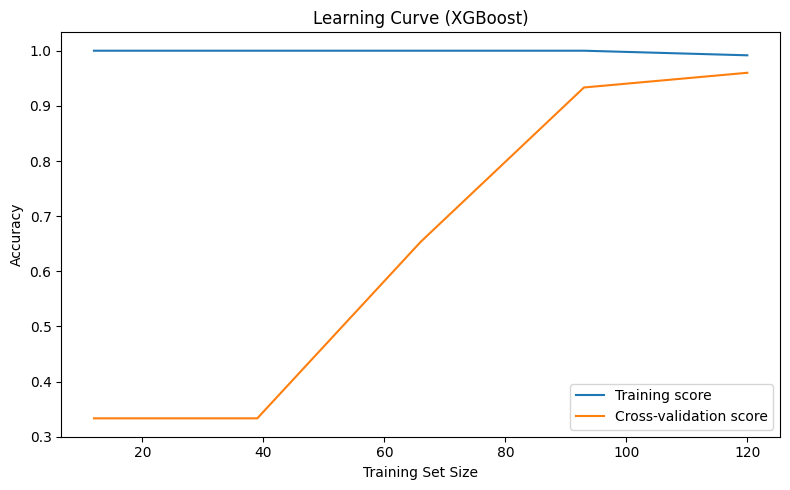

In [16]:
from sklearn.model_selection import learning_curve

xgb_fresh = xgb.XGBClassifier(
    eval_metric="mlogloss",
    random_state=42
)

train_sizes, train_scores, test_scores = learning_curve(
    xgb_fresh, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), error_score='raise'
)
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (XGBoost)")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='accuracy')

print("Cross-validated accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))


Cross-validated accuracy: 0.9533 ± 0.0340


# Parameter Tuning

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best accuracy: 0.96


In [19]:
final_model = XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100,
    subsample=1,
    eval_metric='mlogloss'
)

final_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = final_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=iris.target_names))


[[15  0  0]
 [ 0 14  1]
 [ 0  1 14]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.93      0.93      0.93        15
   virginica       0.93      0.93      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



In [21]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(final_model, X, y, cv=cv, scoring='accuracy')

print("Cross-validated accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))

Cross-validated accuracy: 0.9600 ± 0.0442


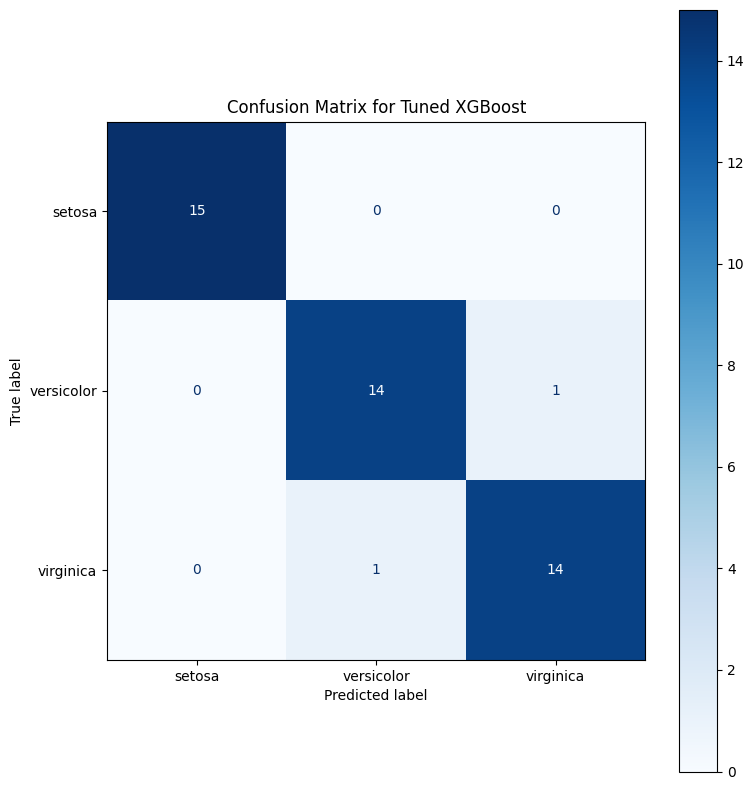

In [22]:
y_pred = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix for Tuned XGBoost")
plt.tight_layout()
plt.show()

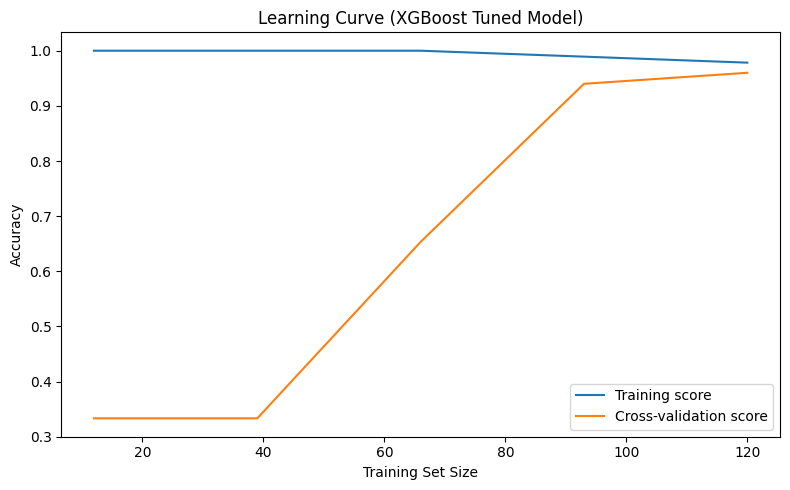

In [23]:
xgb_fresh_tuned = xgb.XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100,
    subsample=1,
    eval_metric='mlogloss',
    random_state=42
)

train_sizes, train_scores, test_scores = learning_curve(
    xgb_fresh_tuned, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), error_score='raise'
)
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (XGBoost Tuned Model)")
plt.legend()
plt.tight_layout()
plt.show()

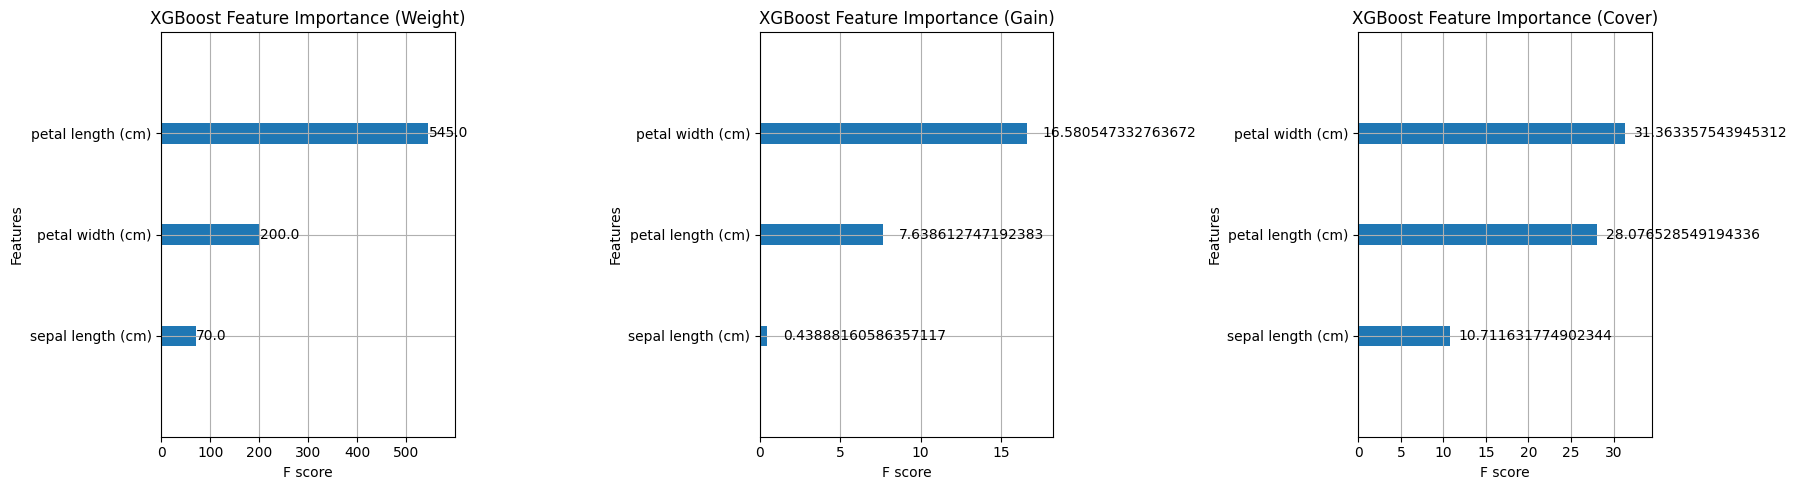

In [24]:
importance_types = ['weight', 'gain', 'cover']
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, imp_type in enumerate(importance_types):
    xgb.plot_importance(final_model, importance_type=imp_type, ax=axs[i], title=f"XGBoost Feature Importance ({imp_type.capitalize()})", show_values=True)
    axs[i].set_xlabel("F score")
    axs[i].set_ylabel("Features")

plt.tight_layout()
plt.show()

# Model Interpretability

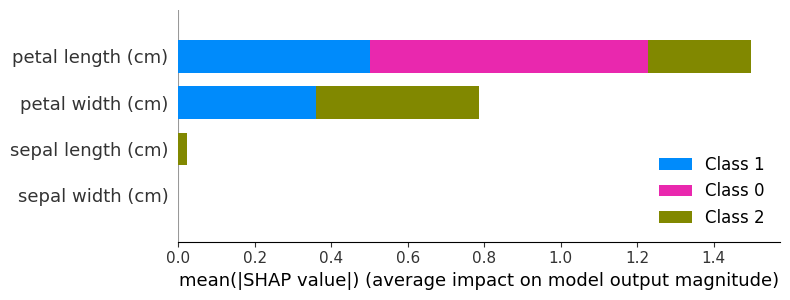

In [26]:
#SHAP

import shap

explainer = shap.Explainer(final_model)
shap_values = explainer(X_train)

# Plot 1: Summary plot
shap.summary_plot(shap_values, X_train)


# Model Exporting

In [27]:
import joblib
joblib.dump(final_model, "xgb_iris_final.pkl")

['xgb_iris_final.pkl']